In [1]:
import multiprocessing
import time
from functools import partial

import matplotlib.pyplot as plt
# In[1]:
# =============================================================================
# 2 (Imports and Setup) ---
# =============================================================================
import numpy as np
import qutip as qt
import logging



# Configure logging for the notebook environment
# Logging will output to the standard output (Jupyter cell output)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

logging.info("Libraries imported and logging configured.")

from cspsa2 import run_instrumental_continuous_cspsa_simulation,run_instrumental_cspsa_simulation, run_chsh_cspsa_simulation
from sga2 import run_instrumental_sga_simulation, run_chsh_sga_simulation

2025-07-19 11:02:03,935 - INFO - Libraries imported and logging configured.


In [2]:

# =============================================================================
# --- 2. 状态生成函数 (State Generation Functions) ---
# =============================================================================
# The simpler way to get the state vector for the |Φ+> Bell state
# Convert to a density matrix
ket0, ket1 = qt.basis(2, 0), qt.basis(2, 1)
psi_pure = 1/np.sqrt(2) * (qt.tensor(ket0, ket0) + qt.tensor(ket1, ket1))
mae_state = qt.ket2dm(psi_pure)
# 生成一个随机混合态
def generate_random_mixed_state():
    dm = qt.rand_dm(4, distribution='hs')
    dm.dims = [[2, 2], [2, 2]]
    return dm

rms1 = generate_random_mixed_state()
rms2 = generate_random_mixed_state()
rms3 = generate_random_mixed_state()
rms4 = generate_random_mixed_state()

In [3]:
# =============================================================================
# --- 4a. ✅ 任务1a 配置: 效率对比 ---
# =============================================================================
# 固定超参数，对比不同量子态
ALGORITHMS_1a = {'CSPSA': run_chsh_cspsa_simulation, 'SGA': run_chsh_sga_simulation}
HPARAMS_1a = {
    'default': {
        'cspsa': {'a': 1.0, 's': 1.0, 'b': 0.25, 'r': 1/6.0},
        'sga': {'a': 1.0, 's': 1.0, 'b': 0.25, 'r': 1/6.0}
    }
}
STATES_1a = {
    "MES": mae_state,
    "RMS1": rms1,
    "RMS2": rms2,
}
PHOTON_NUMs_1a = {'1e1': 1e1, '1e2': 1e2, '1e3': 1e3, '1e4': 1e4, '1e5': 1e5, '1e6': 1e6, '1e7': 1e7, '1e8': 1e8, '1e9': 1e9, '1e10': 1e10}
#QUANTUM_TESTs_1a = {'Instrumental': 0}
STATES_VARIATIONS_1a = {"zero": 0}
MEASUREMENT_UNCERTAINTY_1a = {"zero": 0}
CONFIG_1a = {'iterations':300, 'num_repetitions': 100}

In [4]:

# =============================================================================
# --- 4b. ✅ 任务1b 配置: 超参数影响 ---
# =============================================================================
# 固定量子态，对比不同超参数
ALGORITHMS_1b = {'CCSPSA': run_instrumental_continuous_cspsa_simulation,'CSPSA': run_instrumental_cspsa_simulation, 'SGA': run_instrumental_sga_simulation}
HPARAMS_1b ={
    'default': {
        'ccspsa': {'a': 1.0, 's': 1.0, 'b': 0.25, 'r': 1/6.0},
        'cspsa': {'a': 1.0, 's': 1.0, 'b': 0.25, 'r': 1/6.0},
        'sga': {'a': 1.0, 's': 1.0, 'b': 0.25, 'r': 1/6.0}
    }
}
STATES_1b = {
    "MES": mae_state,
    "RMS1": rms1,
    "RMS2": rms2,
}
PHOTON_NUMs_1b = {'1e1': 1e1, '1e2': 1e2, '1e3': 1e3, '1e4': 1e4, '1e5': 1e5, '1e6': 1e6, '1e7': 1e7, '1e8': 1e8, '1e9': 1e9, '1e10': 1e10}
#QUANTUM_TESTs_1b = {'Instrumental': 0}
STATES_VARIATIONS_1b = {"zero": 0}
MEASUREMENT_UNCERTAINTY_1b = {"zero": 0}
CONFIG_1b = {'iterations':300, 'num_repetitions': 100}

In [5]:

# =============================================================================
# --- 5. 实验执行循环 (Run Simulations) ---
# =============================================================================
def run_simulations(task_name, algorithms, hparams, states,photon_nums,state_variations,uncertainties, config):
    all_results = []
    print(f"\n>>>>>> STARTING TASK: {task_name} <<<<<<")
    start_time = time.time()
    for hparam_name, hparam_values in hparams.items():
        for state_name, state_rho in states.items():
            for photon_num_name, photon_num_values in photon_nums.items():
                for state_variation_name, state_variation_values in state_variations.items():
                    for uncertainty_name, uncertainty_values in uncertainties.items():
                        for algo_name in algorithms:
                            print(f"...Running: [Algo: {algo_name}] |[Uncertainty: {uncertainty_name}]| [state_variation: {state_variation_name}]|[photon used: {photon_num_name}]|[State: {state_name}] | [Hparam: {hparam_name}]...")
                            current_config = {'state': state_rho, 'hparams': hparam_values, 'photon_num':photon_num_values,'state_variation':state_variation_values,'uncertainty':uncertainty_values,**config}

                            # CORRECT INDENTATION: The following block has been moved inside the `for algo_name...` loop.
                            worker_function = partial(algorithms[algo_name], current_config)
                            with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
                                histories = pool.map(worker_function, range(config['num_repetitions']))
                            mean_history = np.mean(np.abs(histories), axis=0)
                            standard_deviation_history = np.std(np.abs(histories), axis=0)
                            all_results.append({
                                'hparam_set': hparam_name,
                                'state_name': state_name,
                                'photon_num_name': photon_num_name,
                                'photon_num_value': photon_num_values,
                                'state_variation_name': state_variation_name,
                                'uncertainty_name': uncertainty_name,
                                'algo_name': algo_name,
                                'mean_history': mean_history,
                                'standard_deviation_history': standard_deviation_history,
                            })
    end_time = time.time()
    print(f">>>>>> TASK {task_name} COMPLETE IN {end_time - start_time:.2f} s <<<<<<\n")
    return all_results

if __name__ == '__main__':
    results_1a = run_simulations("1a: States", ALGORITHMS_1a, HPARAMS_1a, STATES_1a,PHOTON_NUMs_1a,STATES_VARIATIONS_1a,MEASUREMENT_UNCERTAINTY_1a, CONFIG_1a)
results_1b = run_simulations("1b: Hyperparameters", ALGORITHMS_1b, HPARAMS_1b, STATES_1b, PHOTON_NUMs_1b,STATES_VARIATIONS_1b,MEASUREMENT_UNCERTAINTY_1b, CONFIG_1b)



>>>>>> STARTING TASK: 1a: States <<<<<<
...Running: [Algo: CSPSA] |[Uncertainty: zero]| [state_variation: zero]|[photon used: 1e1]|[State: MES] | [Hparam: default]...
  - [CSPSA] Starting Trial 21...
  - [CSPSA] Starting Trial 41...
  - [CSPSA] Starting Trial 61...
  - [CSPSA] Starting Trial 81...
...Running: [Algo: SGA] |[Uncertainty: zero]| [state_variation: zero]|[photon used: 1e1]|[State: MES] | [Hparam: default]...
  - [CSPSA] Starting Trial 21...
  - [CSPSA] Starting Trial 41...
  - [CSPSA] Starting Trial 61...
  - [CSPSA] Starting Trial 81...
...Running: [Algo: CSPSA] |[Uncertainty: zero]| [state_variation: zero]|[photon used: 1e2]|[State: MES] | [Hparam: default]...
  - [CSPSA] Starting Trial 21...
  - [CSPSA] Starting Trial 41...
  - [CSPSA] Starting Trial 61...
  - [CSPSA] Starting Trial 81...
...Running: [Algo: SGA] |[Uncertainty: zero]| [state_variation: zero]|[photon used: 1e2]|[State: MES] | [Hparam: default]...
  - [CSPSA] Starting Trial 21...
  - [CSPSA] Starting Trial

In [15]:
fig3_sub1_CSPSA=[]
fig3_sub1_SGA=[]
iteration = 300
for result in results_1a:
   if result['algo_name'] == 'CSPSA' and result['state_name'] == 'MES' and result['photon_num_value'] > 1e1:
      fig3_sub1_CSPSA.append([result['photon_num_value'],result['mean_history'][iteration]/(2*np.sqrt(2)),result['standard_deviation_history'][iteration]/(2*np.sqrt(2))])
   if result['algo_name'] == 'SGA' and result['state_name'] == 'MES':
      fig3_sub1_SGA.append([result['photon_num_value'],result['mean_history'][iteration]/(2*np.sqrt(2)),result['standard_deviation_history'][iteration]/(2*np.sqrt(2))])

fig3_sub2_CSPSA=[]
fig3_sub2_SGA=[]
for result in results_1b:
    if result['algo_name'] == 'CSPSA' and result['state_name'] == 'MES' and result['photon_num_value'] > 1e1:
       fig3_sub2_CSPSA.append([result['photon_num_value'],result['mean_history'][iteration]/(1+2*np.sqrt(2)),result['standard_deviation_history'][iteration]/(1+2*np.sqrt(2))])
    if result['algo_name'] == 'SGA' and result['state_name'] == 'MES':
       fig3_sub2_SGA.append([result['photon_num_value'],result['mean_history'][iteration]/(1+2*np.sqrt(2)),result['standard_deviation_history'][iteration]/(1+2*np.sqrt(2))])

In [18]:
fig3_sub1_CSPSA = []
fig3_sub1_SGA = []
iteration = 300
for result in results_1a:
    if result['algo_name'] == 'CSPSA' and result['state_name'] == 'MES' and 1e2 <= result[
        'photon_num_value'] <= 1e10:  # 修改条件
        fig3_sub1_CSPSA.append([result['photon_num_value'], result['mean_history'][iteration] / (2 * np.sqrt(2)),
                                result['standard_deviation_history'][iteration] / (2 * np.sqrt(2))])
    if result['algo_name'] == 'SGA' and result['state_name'] == 'MES' and 1e2 <= result[
        'photon_num_value'] <= 1e10:  # 修改条件
        fig3_sub1_SGA.append([result['photon_num_value'], result['mean_history'][iteration] / (2 * np.sqrt(2)),
                              result['standard_deviation_history'][iteration] / (2 * np.sqrt(2))])

fig3_sub2_CSPSA = []
fig3_sub2_SGA = []
for result in results_1b:
    if result['algo_name'] == 'CSPSA' and result['state_name'] == 'MES' and 1e2 <= result[
        'photon_num_value'] <= 1e10:  # 修改条件
        fig3_sub2_CSPSA.append([result['photon_num_value'], result['mean_history'][iteration] / (1 + 2 * np.sqrt(2)),
                                result['standard_deviation_history'][iteration] / (1 + 2 * np.sqrt(2))])
    if result['algo_name'] == 'SGA' and result['state_name'] == 'MES' and 1e2 <= result[
        'photon_num_value'] <= 1e10:  # 修改条件
        fig3_sub2_SGA.append([result['photon_num_value'], result['mean_history'][iteration] / (1 + 2 * np.sqrt(2)),
                              result['standard_deviation_history'][iteration] / (1 + 2 * np.sqrt(2))])

In [21]:
class PlotGenerator:
    """
    A class to generate and combine plots based on experimental data.
    """

    def __init__(self):
        logging.info("PlotGenerator initialized.")

    def generate_combined_plots(self, fig3_sub1_CSPSA, fig3_sub1_SGA, fig3_sub2_CSPSA, fig3_sub2_SGA):
        """
        Generates a single figure with two subplots, combining the CHSH test and
        Instrumental test results.

        Args:
            fig3_sub1_CSPSA (list): Data for CHSH test (CSPSA) in format [[x, line, bar], ...].
            fig3_sub1_SGA (list): Data for CHSH test (SGA) in format [[x, line, bar], ...].
            fig3_sub2_CSPSA (list): Data for Instrumental test (CSPSA) in format [[x, line, bar], ...].
            fig3_sub2_SGA (list): Data for Instrumental test (SGA) in format [[x, line, bar], ...].
        """
        logging.info("Starting generation of combined plots.")

        # Create a figure with two subplots (1 row, 2 columns)
        # Adjusted figsize to accommodate two plots horizontally for better clarity as subplots
        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle('Combined Quantum Tests', fontsize=24, y=1.02) # Overall title for the figure above both subplots

        bar_width = 8 # Define bar width for consistency across subplots

        # --- Plot 1: CHSH Test (Left Subplot - ax0) ---
        logging.info("Processing CHSH test data for subplot (a).")
        x_CSPSA_chsh = [item[0] for item in fig3_sub1_CSPSA]
        y_CSPSA_line_chsh = [item[1] for item in fig3_sub1_CSPSA]
        y_CSPSA_bar_chsh = [item[2] for item in fig3_sub1_CSPSA]

        x_SGA_chsh = [item[0] for item in fig3_sub1_SGA]
        y_SGA_line_chsh = [item[1] for item in fig3_sub1_SGA]

        y_SGA_bar_chsh = [item[2] for item in fig3_sub1_SGA]

        x_coords_np_chsh = np.array(x_CSPSA_chsh)

        # Set plot title for the first subplot
        ax0.set_title('CHSH test', fontsize=20)



        # --- Plot 1 (CHSH Test) 修改 ---
        ax0.set_xlabel('Number of photons', fontsize=20)
        ax0.set_ylabel('Violation', color='black', fontsize=20)
        ax0.plot(x_CSPSA_chsh, y_CSPSA_line_chsh, color='blue', marker='o', markersize=6, linestyle='-', label='CSPSA')
        ax0.plot(x_SGA_chsh, y_SGA_line_chsh, color='red', marker='o', markersize=6, linestyle='-', label='SGA')
        ax0.set_xscale('log')  # 新增：设置x轴为对数刻度

        # Configure ticks for the first subplot
        ax0.tick_params(axis='x', labelcolor='black', labelsize=16)
        ax0.tick_params(axis='y', labelcolor='black', labelsize=16)


        ax0.set_ylim(0.9, 1.0) # Set the y-axis range based on original plot 1

        # Create the second y-axis (twinx) for bar plots on the first subplot
        ax2_0 = ax0.twinx()
        ax2_0.set_yticklabels([])  # 新增：隐藏右侧y轴刻度标签

        # Plot the BAR plot on the second y-axis (ax2_0 - right)
        # CSPSA bars (blue), shifted left for distinction
        ax2_0.bar(np.array(x_coords_np_chsh) * (1 - bar_width/20), y_CSPSA_bar_chsh,
                 width=x_coords_np_chsh * bar_width/10, color='red')
        ax2_0.bar(np.array(x_coords_np_chsh) * (1 + bar_width/20), y_SGA_bar_chsh,
                 width=x_coords_np_chsh * bar_width/10, color='blue')

        # Configure ticks and label for the twin y-axis of the first subplot
        ax2_0.tick_params(axis='y', labelcolor='black', labelsize=16)
        ax2_0.set_ylim(0, 0.1) # Set the y-axis range based on original plot 1
        #ax2_0.set_ylabel('Std. Deviation', color='black', fontsize=20)

        # Add grid, legend, and annotation for the first subplot
        ax0.grid(True, linestyle=':', color='grey', alpha=0.6)
        ax0.set_axisbelow(True) # Ensure grid is in the background

        ax0.legend(loc='center right', frameon=True, fontsize=20) # Legend for line plots only
        ax0.text(10, 0.85, '(a)', fontsize=28) # Annotation

        # --- Plot 2: Instrumental Test (Right Subplot - ax1) ---
        logging.info("Processing Instrumental test data for subplot (b).")
        x_CSPSA_inst = [item[0] for item in fig3_sub2_CSPSA]
        y_CSPSA_line_inst = [item[1] for item in fig3_sub2_CSPSA]
        y_CSPSA_bar_inst = [item[2] for item in fig3_sub2_CSPSA]

        x_SGA_inst = [item[0] for item in fig3_sub2_SGA]
        y_SGA_line_inst = [item[1] for item in fig3_sub2_SGA]
        y_SGA_bar_inst = [item[2] for item in fig3_sub2_SGA]

        x_coords_np_inst = np.array(x_CSPSA_inst)

        # Set plot title for the second subplot
        ax1.set_title('Instrumental test', fontsize=20)

        # Plot the LINE plot on the main y-axis of the second subplot (ax1 - left)
        ax1.set_xlabel('Number of photons', fontsize=20)
        ax1.set_yticklabels([])  # 新增：隐藏左侧y轴刻度标签
        #ax1.set_ylabel('Violation', color='black', fontsize=20) # Retained for symmetry as per original request

        ax1.set_xscale('log')  # 新增：设置x轴为对数刻度
        ax1.plot(x_CSPSA_inst, y_CSPSA_line_inst, color='blue', marker='o', markersize=6, linestyle='-', label='CSPSA')
        ax1.plot(x_SGA_inst, y_SGA_line_inst, color='red', marker='o', markersize=6, linestyle='-', label='SGA')


        # Configure ticks for the second subplot
        ax1.tick_params(axis='x', labelcolor='black', labelsize=16)
        ax1.tick_params(axis='y', labelcolor='black', labelsize=16)

        ax1.set_ylim(0.9, 1.0) # Set the y-axis range based on original plot 2

        # Create the second y-axis (twinx) for bar plots on the second subplot
        ax2_1 = ax1.twinx()
        ax2_1.set_ylabel('Std. Deviation', color='black', fontsize=20)

        # Plot the BAR plot on the second y-axis (ax2_1 - right)
        ax2_1.bar(np.array(x_coords_np_inst) * (1 - bar_width/20), y_CSPSA_bar_inst,
                 width=x_coords_np_inst * bar_width/10, color='red')
        ax2_1.bar(np.array(x_coords_np_inst) * (1 + bar_width/20), y_SGA_bar_inst,
                 width=x_coords_np_inst * bar_width/10, color='blue')

        # Configure ticks and label for the twin y-axis of the second subplot
        ax2_1.tick_params(axis='y', labelcolor='black', labelsize=16)
        ax2_1.set_ylim(0, 0.1) # Set the y-axis range based on original plot 2
        ax2_1.set_ylabel('Std. Deviation', color='black', fontsize=20)

        # Add grid, legend, and annotation for the second subplot
        ax1.grid(True, linestyle=':', color='grey', alpha=0.6)
        ax1.set_axisbelow(True) # Ensure grid is in the background

        ax1.legend(loc='center right', frameon=True, fontsize=20) # Legend for line plots only
        ax1.text(10, 0.85, '(b)', fontsize=28) # Annotation

        # Ensure the overall plot layout is tight, adjusting for the suptitle
        fig.tight_layout(rect=[0, 0.03, 1, 0.95], w_pad=0.01)  # 新增：调整w_pad参数

        plt.savefig("figure3_instrumental_chsh_compare.pdf", format='pdf', bbox_inches='tight')
        plt.show()
        logging.info("Combined plots generated and displayed.")

2025-07-19 12:34:03,358 - INFO - Creating PlotGenerator instance and calling generate_combined_plots.
2025-07-19 12:34:03,359 - INFO - PlotGenerator initialized.
2025-07-19 12:34:03,359 - INFO - Starting generation of combined plots.
2025-07-19 12:34:03,428 - INFO - Processing CHSH test data for subplot (a).
2025-07-19 12:34:03,441 - INFO - Processing Instrumental test data for subplot (b).


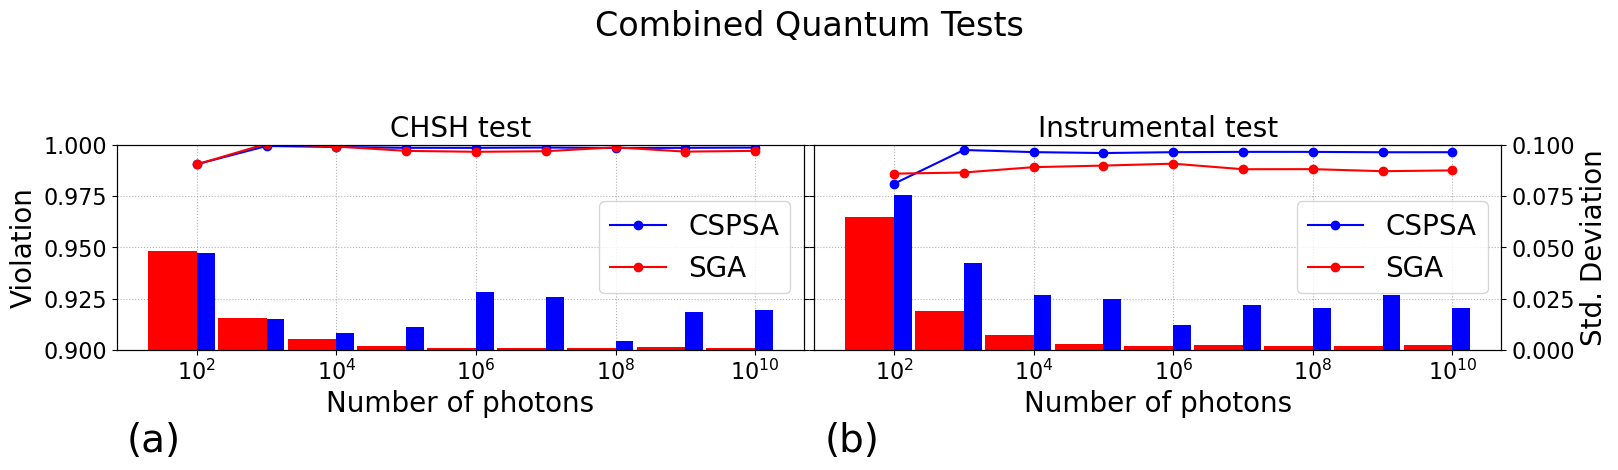

2025-07-19 12:34:03,760 - INFO - Combined plots generated and displayed.
2025-07-19 12:34:03,761 - INFO - Execution complete.


In [22]:
# Dummy data to make the example runnable within Jupyter
# CHSH Test Data (fig3_sub1)
# Instantiate the PlotGenerator and call the method to generate plots
logging.info("Creating PlotGenerator instance and calling generate_combined_plots.")
plot_gen = PlotGenerator()
plot_gen.generate_combined_plots(fig3_sub1_CSPSA, fig3_sub1_SGA, fig3_sub2_CSPSA, fig3_sub2_SGA)

logging.info("Execution complete.")